In [1]:
import matplotlib.pyplot as pltimport
import xhermes as xh
from boutdata.data import BoutData
from boutdata import collect
import matplotlib.pyplot as plt
import glob     
import re
import numpy as np
import pandas as pd
from heatflux_functions import *
from data_accessors import *
import xarray as xr

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15


plt.style.use('ggplot')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 14})


def replace_guards(var):
    """
	This in-place replaces the points in the guard cells with the points on the boundary
    
    """
    # Strip the edge guard cells
    var = var[1:-1]

    var[0] = 0.5*(var[0] + var[1])
    var[-1] = 0.5*(var[-1] + var[-2])
    return var

In [1]:
def replace_guards(var):
    """
    This in-place replaces the points in the guard cells with the points 
    on the boundary.
    """
    var = var[1:-1]  # Strip the edge guard cells

    var[0] = 0.5 * (var[0] + var[1])
    var[-1] = 0.5 * (var[-1] + var[-2])
    
    return var

import os
import xarray as xr
from boutdata import collect

def load_simulation_data(base_dir, alpha_values, neon_values, replace_guards=True):
    data = {}
    for alpha in alpha_values:
        for neon in neon_values:
            # Construct the path to the specific simulation
            sim_path = os.path.join(base_dir, f'alpha_{alpha}', f'neon_{neon}')
            try:
                print(f'Loading data for alpha={alpha}, neon={neon}')
                # Load the latest timestep (t=-1) using BOUT's load.case_1D method
                ds = Load.case_1D(sim_path).ds.isel(t=-1)
                
                # If replace_guards is True, apply the function to each variable
                if replace_guards:
                    for var_name in ds.data_vars:
                        ds[var_name].data = replace_guards(ds[var_name].data)
                
                data[(alpha, neon)] = ds
            except Exception as e:
                print(f"Failed to load data for alpha={alpha}, neon={neon}: {e}")
    
    return data

# Define your parameters
base_dir = "/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2024-08-11_selective_collisions_old_collision_setup"
alpha_values = ['snb']
neon_values = ['0.0', '0.02', '0.04', '0.06', '0.08', '0.1']

# Load the data with guard replacement
simulation_data = load_simulation_data(base_dir, alpha_values, neon_values, replace_guards=True)


Loading data for alpha=snb, neon=0.0
Failed to load data for alpha=snb, neon=0.0: name 'Load' is not defined
Loading data for alpha=snb, neon=0.02
Failed to load data for alpha=snb, neon=0.02: name 'Load' is not defined
Loading data for alpha=snb, neon=0.04
Failed to load data for alpha=snb, neon=0.04: name 'Load' is not defined
Loading data for alpha=snb, neon=0.06
Failed to load data for alpha=snb, neon=0.06: name 'Load' is not defined
Loading data for alpha=snb, neon=0.08
Failed to load data for alpha=snb, neon=0.08: name 'Load' is not defined
Loading data for alpha=snb, neon=0.1
Failed to load data for alpha=snb, neon=0.1: name 'Load' is not defined


In [2]:
ds = pd.read_pickle('/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/flux_limit/Flux_limiter_detachment_ITER_final.pickle')


In [3]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]
x_point = 42
x = sh['y']

x_point_index = np.argmin(np.abs(x - x_point))


power_injection_electrons = np.array([4e8]*len(x[:]))
power_injection_ions = np.array([4e8]*len(x[:]))
power_injection_total = power_injection_electrons + power_injection_ions
power_injection_total = power_injection_total


Spitzer-Harm heat flux as calculated in hermes-3 and BOUT++ https://bout-dev.readthedocs.io/en/stable/user_docs/nonlocal.html

$$
Q_{SH,e} = - \frac{n_{e}eT_{e}3\sqrt{ \pi }}{4m_{e}}\cdot \tau_{ei,T}\kappa_{0} \cdot \frac{Z+0.24}{Z+4.2}\partial_{\parallel}T_{e}
$$

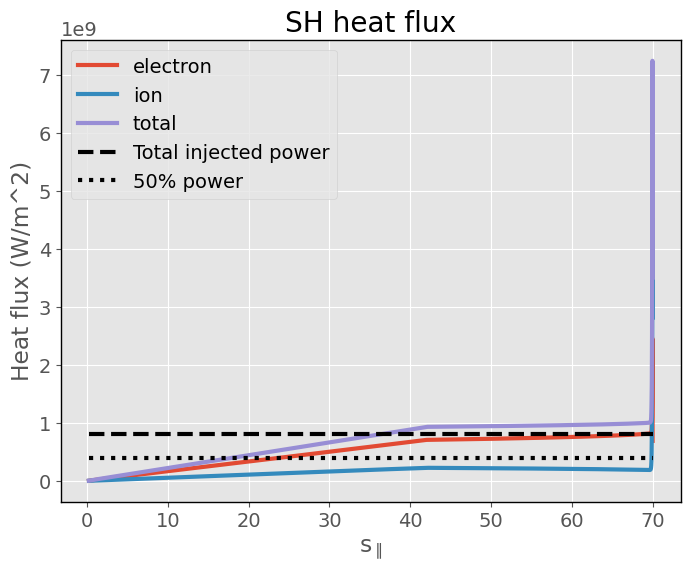

In [4]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

x = sh['y']
q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)


q_total = q_electron + q_ion
electron_injection = power_injection_total/2

fig,ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, q_electron, label='electron', linewidth=linewidth)
ax.plot(x, q_ion, label='ion', linewidth=linewidth)
ax.plot(x, q_total, label='total', linewidth=linewidth)
ax.plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax.plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')


ax.set_title('SH heat flux')
# ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()

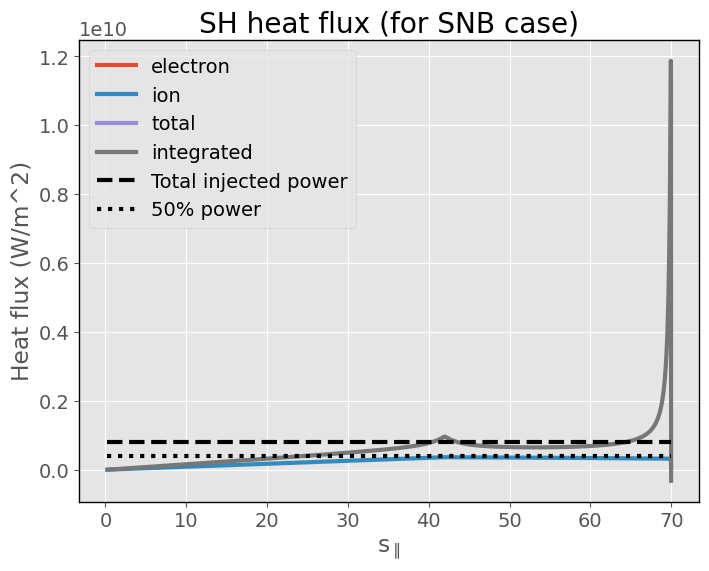

In [12]:
sh = ds[(ds['alpha'] == 'SNB') & (ds['neon_frac'] == 0.0)]

x = sh['y']
q_electron = spitzer_q_electron_simple(sh) * 1e-2
q_ion = spitzer_q_ion_simple(sh) * 1e-2

q_electron_integrated_SH = divq_integrate(sh, False)

q_electron_integrated_SNB = divq_integrate(sh, True)

q_total = q_electron + q_ion

electron_injection = power_injection_total/2

fig,ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, q_electron, label='electron', linewidth=linewidth)
ax.plot(x, q_ion, label='ion', linewidth=linewidth)
ax.plot(x, q_total, label='total', linewidth=linewidth)
ax.plot(x, q_electron_integrated_SH, label='integrated', linewidth=linewidth)
ax.plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax.plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')


ax.set_title('SH heat flux (for SNB case)')
# ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()

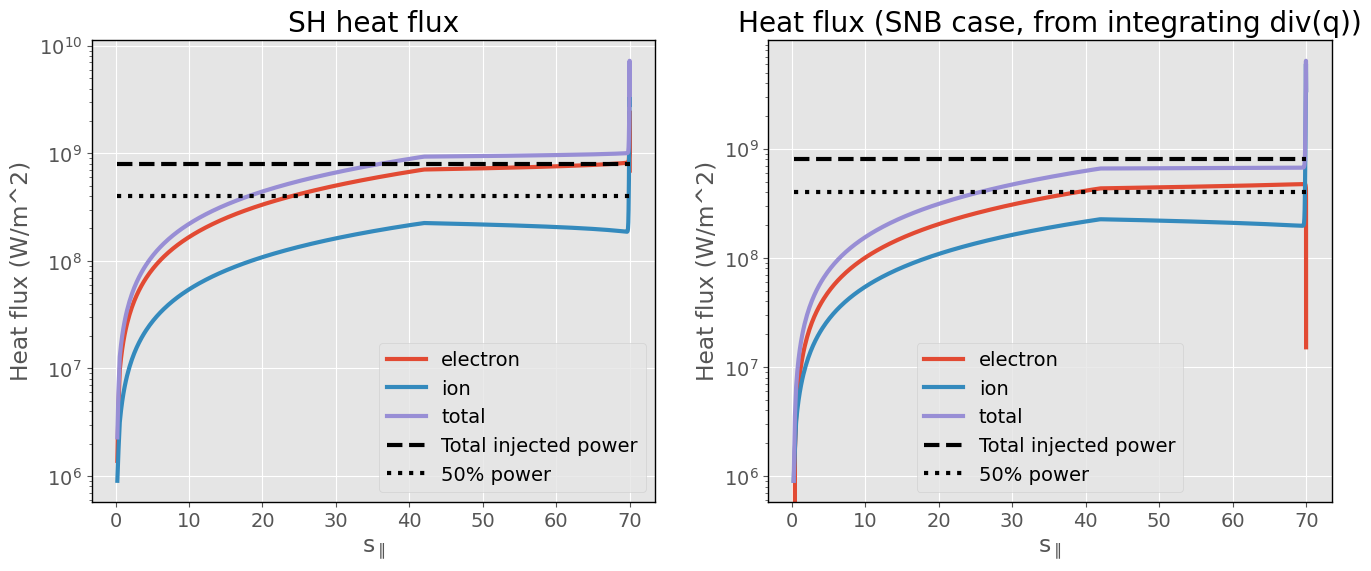

In [6]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]
x = sh['y']
q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)


q_total = q_electron + q_ion
electron_injection = power_injection_total/2



snb_ds = ds[(ds['alpha'] == 'SNB') & (ds['neon_frac'] == 0.0)]

x = snb_ds['y']

q_electron_integrated_SH = divq_integrate(snb_ds, False)

q_electron_integrated_SNB = divq_integrate(snb_ds, True)
q_ion_SNB = spitzer_q_ion(snb_ds)

total = q_electron_integrated_SNB + q_ion_SNB

fig,ax = plt.subplots(1,2, figsize=(16,6))

# ax.plot(x, q_electron_integrated_SH, label='SH', linewidth=linewidth)
ax[0].plot(x, q_electron, label='electron', linewidth=linewidth)
ax[0].plot(x, q_ion, label='ion', linewidth=linewidth)
ax[0].plot(x, q_total, label='total', linewidth=linewidth)
ax[0].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[0].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')


ax[0].set_title('SH heat flux')
ax[0].set_yscale('log')
ax[0].set_ylabel('Heat flux (W/m^2)')
ax[0].set_xlabel(r's$_{\parallel}$')
ax[0].legend()

ax[1].plot(x, q_electron_integrated_SNB, label='electron', linewidth=linewidth)
ax[1].plot(x, q_ion_SNB, label='ion', linewidth=linewidth)
ax[1].plot(x, total, label='total', linewidth=linewidth)
ax[1].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[1].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[1].set_title('Heat flux (SNB case, from integrating div(q))')
ax[1].set_yscale('log')
ax[1].set_ylabel('Heat flux (W/m^2)')
ax[1].set_xlabel(r's$_{\parallel}$')
ax[1].legend()

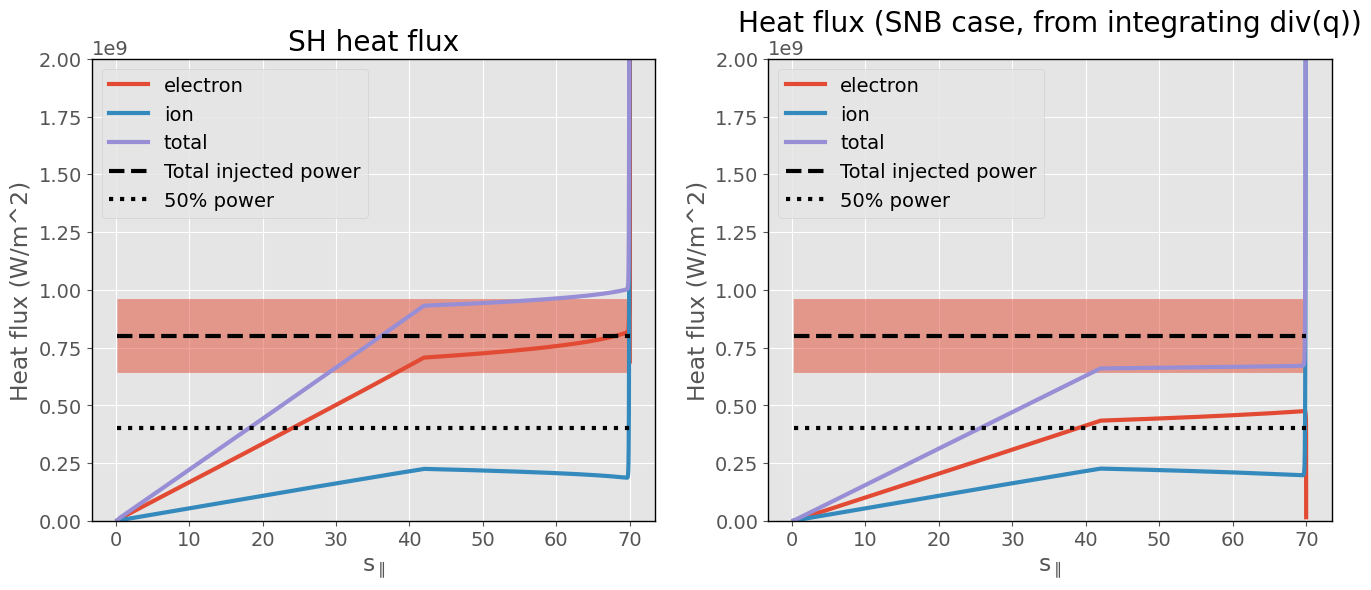

In [7]:
fig,ax = plt.subplots(1,2, figsize=(16,6))

q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)


q_total = q_electron + q_ion
electron_injection = power_injection_total/2



q_electron_integrated_SH = divq_integrate(snb_ds, False)

q_electron_integrated_SNB = divq_integrate(snb_ds, True)
q_ion_SNB = spitzer_q_ion(snb_ds)

total = q_electron_integrated_SNB + q_ion_SNB


# ax.plot(x, q_electron_integrated_SH, label='SH', linewidth=linewidth)
ax[0].plot(x, q_electron, label='electron', linewidth=linewidth)
ax[0].plot(x, q_ion, label='ion', linewidth=linewidth)
ax[0].plot(x, q_total, label='total', linewidth=linewidth)
ax[0].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[0].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[0].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)


ax[0].set_title('SH heat flux')
# ax[0].set_yscale('log')
ax[0].set_ybound(0,2e9)
ax[0].set_ylabel('Heat flux (W/m^2)')
ax[0].set_xlabel(r's$_{\parallel}$')
ax[0].legend()

ax[1].plot(x, q_electron_integrated_SNB, label='electron', linewidth=linewidth)
ax[1].plot(x, q_ion_SNB, label='ion', linewidth=linewidth)
ax[1].plot(x, total, label='total', linewidth=linewidth)
ax[1].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[1].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)

ax[1].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[1].set_title('Heat flux (SNB case, from integrating div(q))')
# ax[1].set_yscale('log')
ax[1].set_ybound(0,2e9)
ax[1].set_ylabel('Heat flux (W/m^2)')
ax[1].set_xlabel(r's$_{\parallel}$')
ax[1].legend()





# Using the very simple formula

$q=-\kappa_e \nabla T_e$

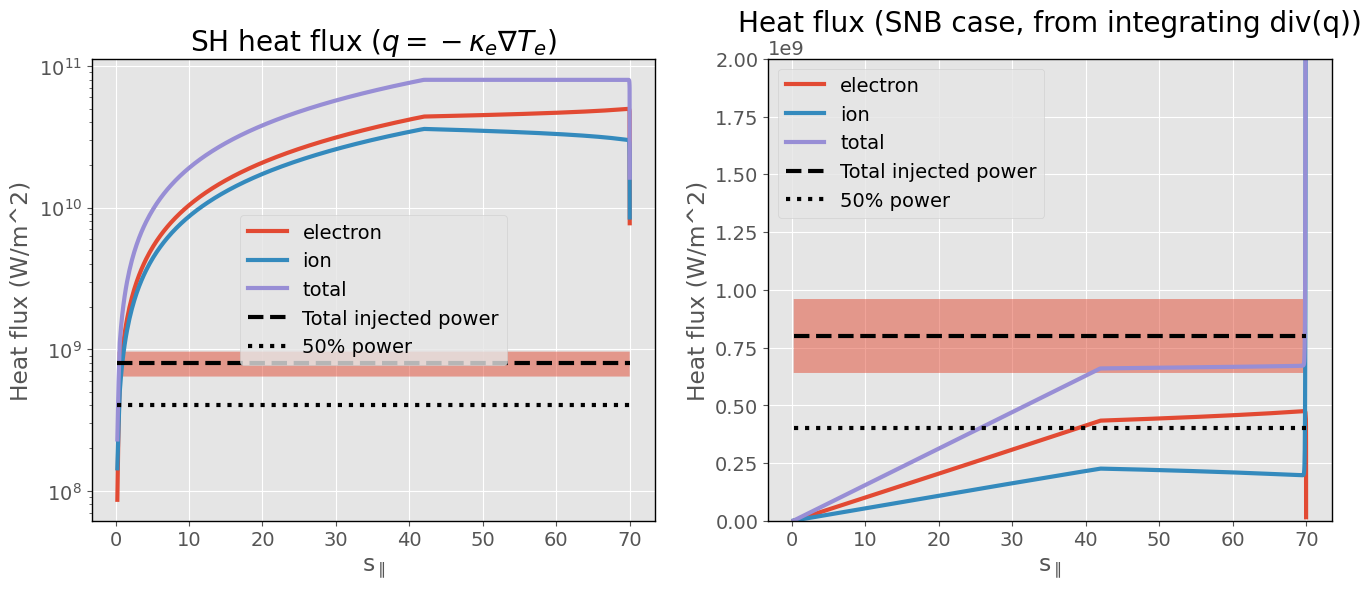

In [8]:
fig,ax = plt.subplots(1,2, figsize=(16,6))

q_electron = spitzer_q_electron_simple(sh)
q_ion = spitzer_q_ion_simple(sh)

q_total = q_electron + q_ion

# ax.plot(x, q_electron_integrated_SH, label='SH', linewidth=linewidth)
ax[0].plot(x, q_electron, label='electron', linewidth=linewidth)
ax[0].plot(x, q_ion, label='ion', linewidth=linewidth)
ax[0].plot(x, q_total, label='total', linewidth=linewidth)
ax[0].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[0].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[0].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)


ax[0].set_title(r'SH heat flux ($q=-\kappa_e \nabla T_e$)')
ax[0].set_yscale('log')
# ax[0].set_ybound(0,2e9)
ax[0].set_ylabel('Heat flux (W/m^2)')
ax[0].set_xlabel(r's$_{\parallel}$')
ax[0].legend()

ax[1].plot(x, q_electron_integrated_SNB, label='electron', linewidth=linewidth)
ax[1].plot(x, q_ion_SNB, label='ion', linewidth=linewidth)
ax[1].plot(x, total, label='total', linewidth=linewidth)
ax[1].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[1].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)

ax[1].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[1].set_title('Heat flux (SNB case, from integrating div(q))')
# ax[1].set_yscale('log')
ax[1].set_ybound(0,2e9)
ax[1].set_ylabel('Heat flux (W/m^2)')
ax[1].set_xlabel(r's$_{\parallel}$')
ax[1].legend()



Bizzarely the SH heat flux is exactly two orders of magnitude higher than it should be, but it is perfectly at 8... which I guess is good?  

# Look at the flux limited variation in Spitzer harm flux

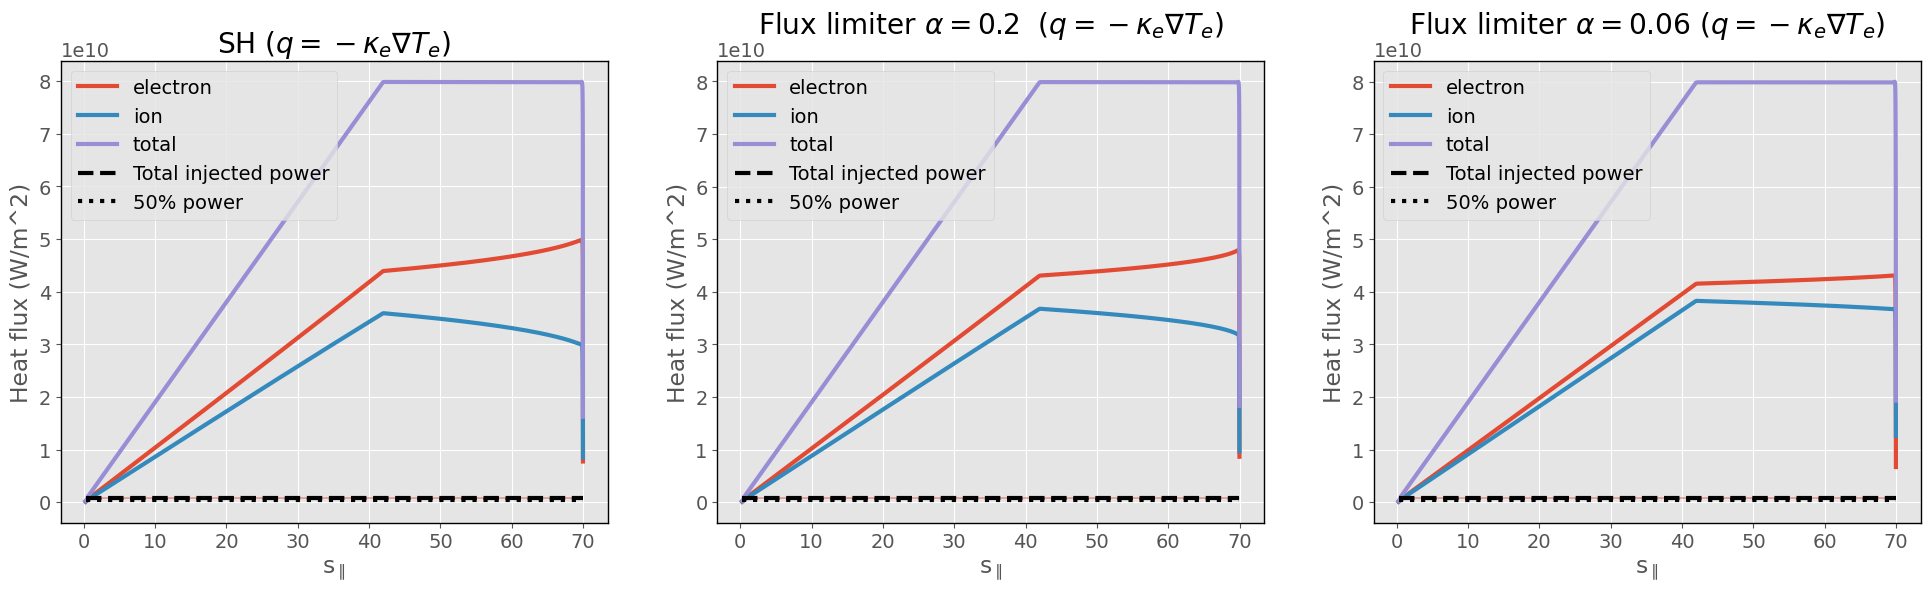

In [9]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

q_electron = spitzer_q_electron_simple(sh)
q_ion = spitzer_q_ion_simple(sh)

q_total = q_electron + q_ion

fl_02 = ds[(ds['alpha'] == '0.2') & (ds['neon_frac'] == 0.0)]

q_electron_fl02 = spitzer_q_electron_simple(fl_02)
q_ion_fl02 = spitzer_q_ion_simple(fl_02)

q_total_fl02 = q_electron_fl02 + q_ion_fl02

fl_006 = ds[(ds['alpha'] == '0.06') & (ds['neon_frac'] == 0.0)]

q_electron_fl006 = spitzer_q_electron_simple(fl_006)
q_ion_fl006 = spitzer_q_ion_simple(fl_006)

q_total_fl006 = q_electron_fl006 + q_ion_fl006


fig,ax = plt.subplots(1,3, figsize=(24,6))

ax[0].plot(x, q_electron, label='electron', linewidth=linewidth)
ax[0].plot(x, q_ion, label='ion', linewidth=linewidth)
ax[0].plot(x, q_total, label='total', linewidth=linewidth)
ax[0].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[0].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[0].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)

ax[1].plot(x, q_electron_fl02, label='electron', linewidth=linewidth)
ax[1].plot(x, q_ion_fl02, label='ion', linewidth=linewidth)
ax[1].plot(x, q_total_fl02, label='total', linewidth=linewidth)
ax[1].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[1].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[1].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)

ax[2].plot(x, q_electron_fl006, label='electron', linewidth=linewidth)
ax[2].plot(x, q_ion_fl006, label='ion', linewidth=linewidth)
ax[2].plot(x, q_total_fl006, label='total', linewidth=linewidth)
ax[2].plot(x[:], power_injection_total, label='Total injected power', linewidth=linewidth, color = 'black', linestyle='--')
ax[2].plot(x[:], electron_injection, label='50% power', linewidth=linewidth, color = 'black', linestyle=':')
ax[2].fill_between(x[:], power_injection_total*0.8, power_injection_total*1.2, alpha=0.5)

ax[0].set_title(r'SH ($q=-\kappa_e \nabla T_e$)')

ax[1].set_title(r'Flux limiter $\alpha=0.2$  ($q=-\kappa_e \nabla T_e$)')

ax[2].set_title(r'Flux limiter $\alpha=0.06$ ($q=-\kappa_e \nabla T_e$)')


if 1:
    for axes in ax:
        # axes.set_yscale('log')
        axes.set_ylabel('Heat flux (W/m^2)')
        axes.set_xlabel(r's$_{\parallel}$')
        axes.legend()

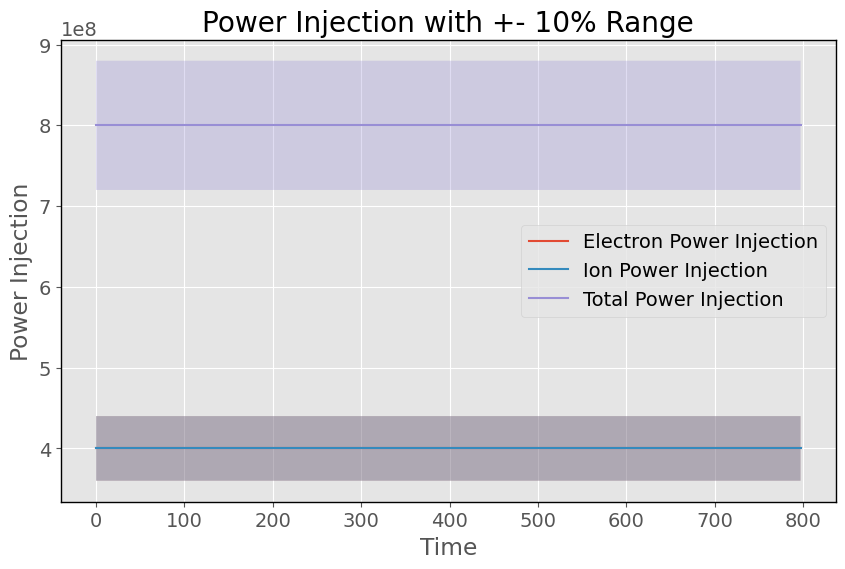

In [10]:
# Plotting power injection
plt.figure(figsize=(10, 6))
plt.plot(power_injection_electrons, label='Electron Power Injection')
plt.plot(power_injection_ions, label='Ion Power Injection')
plt.plot(power_injection_total, label='Total Power Injection')

# Plotting +- 10% range
plt.fill_between(range(len(power_injection_electrons)), power_injection_electrons*0.9, power_injection_electrons*1.1, alpha=0.3)
plt.fill_between(range(len(power_injection_ions)), power_injection_ions*0.9, power_injection_ions*1.1, alpha=0.3)
plt.fill_between(range(len(power_injection_total)), power_injection_total*0.9, power_injection_total*1.1, alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Power Injection')
plt.title('Power Injection with +- 10% Range')
plt.legend()
plt.show()

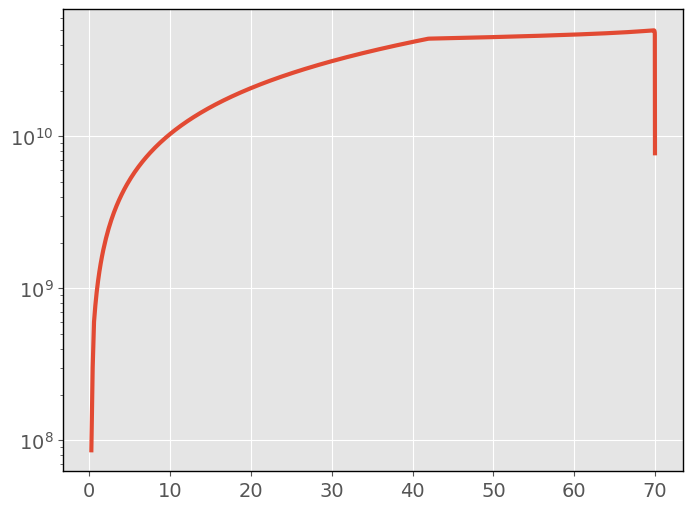

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12), dpi=500)
# ax_inset[0] = inset_axes(ax, width="30%", height="30%", loc='lower left',bbox_to_anchor=(0.2, 0.2, 1, 1), bbox_transform=fig.transFigure)

neon_0_ds = ds[ds['neon_frac'] == 0.0]

for i in neon_0_ds['alpha'].unique():
    ds_i = ds[(ds['alpha'] == i) & (ds['neon_frac'] == 0.0)]
    
    if i not in ['0.1', '0.4']:  # Exclude plotting for alpha = 'SNB'
        print(i)
        if i == 'SH':
            linestyle = '--'
            q = spitzer_q_electron_simple(ds_i) * 1e-8
        elif i == 'SNB':
            linestyle = ':'
            q = divq_integrate(ds_i, snb_int=True) * 1e-6
        else:
            linestyle = '-'
            q = spitzer_q_electron_simple(ds_i)* 1e-8

        ax[0,0].plot(ds_i['y'], ds_i['Te'],
                   label=r'$\alpha$' + f' = {i}', linewidth=linewidth, markersize=markersize, color=colors[i], linestyle=linestyle)
        
        ax[0,1].plot(ds_i['y'], q,
            label=r'$\alpha$' + f' = {i}', linewidth=linewidth, markersize=markersize, color=colors[i], linestyle=linestyle)
        
        ax[1,0].plot(ds_i['y'], ds_i['Ne'],
                   label=r'$\alpha$' + f' = {i}', linewidth=linewidth, markersize=markersize, color=colors[i], linestyle=linestyle)
        
        
        ax[1,1].plot(ds_i['y'], ds_i['Nd'], label=r'$\alpha$' + f' = {i}', linewidth=linewidth, markersize=markersize, color=colors[i], linestyle=linestyle)

